In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import statsmodels.api as sm

In [7]:
os.getcwd()

'/home/jquser'

In [18]:
df = pd.read_csv("Maotai_data.csv",index_col='date')
df.head()

,Unnamed: 0,open,high,low,close,volume,money
date,,,,,,,
2005-01-04,0,36.4,36.80,36.00,36.45,234881.0,8566179.0
2005-01-05,1,36.4,37.28,36.23,37.24,613933.0,22582400.0
2005-01-06,2,37.0,37.10,36.50,36.60,552372.0,20282548.0
2005-01-07,3,36.5,37.20,36.50,36.90,300274.0,11115440.0
2005-01-10,4,36.9,38.30,36.90,38.25,1071811.0,40597723.0


In [82]:
df.tail()

,Unnamed: 0,open,high,low,close,volume,money
date,,,,,,,
2021-04-28,3897,2010.00,2047.50,2003.00,2042.00,8134295.0,1.646357e+10
2021-04-29,3898,2047.04,2049.94,2014.00,2026.36,4128378.0,8.370431e+09
2021-04-30,3899,2026.00,2036.00,2003.71,2006.78,3840137.0,7.723747e+09
2021-05-06,3900,2000.00,2006.84,1953.00,1959.00,5354614.0,1.058497e+10
2021-05-07,3901,1965.00,1967.98,1901.00,1903.00,5249339.0,1.010170e+10


In [20]:
from datetime import datetime #导入datetime模块
df.index=pd.to_datetime(df.index) #转换数据格式
ts=df['close']
ts.head()

date
2005-01-04    36.45
2005-01-05    37.24
2005-01-06    36.60
2005-01-07    36.90
2005-01-10    38.25
Name: close, dtype: float64

Text(0.5, 1.0, '茅台收盘价')

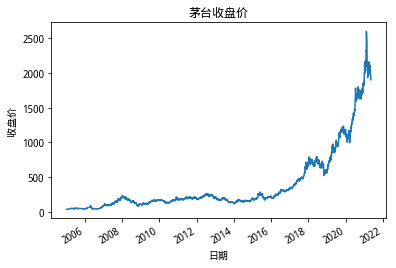

In [21]:
# 收盘价可视化
ts.plot()
plt.xlabel('日期') #横、纵坐标以及标题命名
plt.ylabel('收盘价')
plt.title('茅台收盘价',loc='center')

In [22]:
# 单位根检验
from statsmodels.tsa.stattools import adfuller #ADF单位根检验
result = adfuller(ts) #不能拒绝原假设，即原序列存在单位根
print(result)

(2.6209906680084876, 0.9990787431781716, 29, 3872, {'1%': -3.4320399898051384, '5%': -2.8622867448766596, '10%': -2.567167501411383}, 30440.06526776745)


In [23]:
# 第一个是ADF检验的t值结果：2.621>>t-value
# 进行一阶差分
ts1= ts.diff().dropna() #一阶差分再进行ADF检验
result = adfuller(ts1)
print(result)
# -11.1266 < -3.432: 拒绝原假设，reject单位根存在的H0

(-11.126638757482768, 3.361346676229873e-20, 28, 3872, {'1%': -3.4320399898051384, '5%': -2.8622867448766596, '10%': -2.567167501411383}, 30438.136508413227)


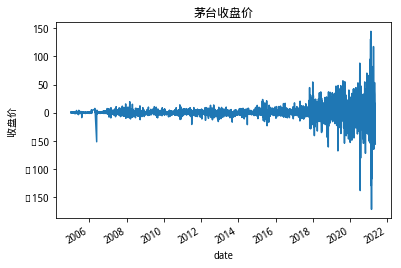

In [24]:
plt.xlabel('日期') #横、纵坐标以及标题命名
plt.ylabel('收盘价')
plt.title('茅台收盘价',loc='center')
ts1.plot()
plt.show() #一阶差分后的时序图

In [38]:
#引入statsmodels和scipy.stats用于画QQ和PP图
import scipy.stats as scs
import statsmodels.tsa.api as smt
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):   
        data = pd.Series(data)
    with plt.style.context('bmh'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0))
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'时序图')
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')        
        scs.probplot(data, sparams=(data.mean(), data.std()), plot=pp_ax)
        pp_ax.set_title('PP 图') 
        plt.tight_layout()
    return

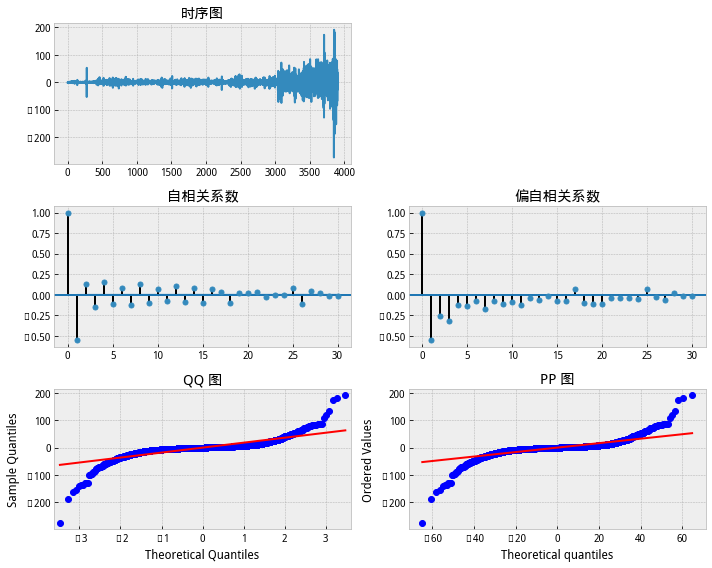

In [39]:
ts_plot(np.diff(ts1), lags=30)

In [42]:
# 白噪声检验
from statsmodels.tsa import stattools #白噪声检验:Ljung-Box检验 
LjungBox=stattools.q_stat(stattools.acf(ts1)[1:11],len(ts1))[1] #显示第一个到第11个白噪声检验的p值 
print(LjungBox) #仅第一个白噪声检验的p值大于0.05；因此拒绝原假设，差分后序列为非白噪声

[0.31470332836853876 9.597196517109094e-08 1.913937998075972e-10
 2.2981800913352698e-17 3.907341916195035e-21 1.808998746571237e-20
 2.516279153596718e-29 6.739377318295906e-31 3.1789233299728546e-34
 7.799517948039843e-34]


In [50]:
from statsmodels.tsa.arima_model import ARIMA #导入ARIMA模型 
model=ARIMA(ts1,order=(2,1,0)) 
result=model.fit(disp=-1) 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 3900
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -15986.650
Method:                       css-mle   S.D. of innovations             14.587
Date:                Tue, 11 May 2021   AIC                          31981.301
Time:                        12:01:16   BIC                          32006.376
Sample:                             1   HQIC                         31990.201
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0124      0.120     -0.104      0.917      -0.247       0.222
ar.L1.D.close    -0.6940      0.015    -44.815      0.000      -0.724      -0.664
ar.L2.D.close    -0.2551      0.015    -16.467      0.000      -0.285      -0.225
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3605           -1.4387j            1.9801           -0.3706
AR.2           -1.3605           +1.4387j            1.9801            0.3706
-----------------------------------------------------------------------------
"""

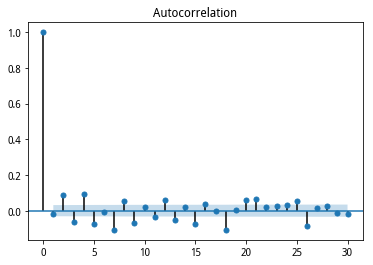

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #导入自相关和偏自相关包 
plot_acf(ts1,use_vlines=True,lags=30) #自相关函数图，滞后30阶 
plt.show()

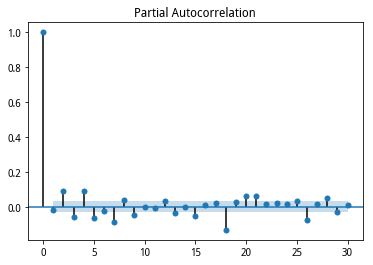

In [52]:
plot_pacf(ts1,use_vlines=True,lags=30) #偏自相关函数图
plt.show()

In [71]:
train_results = sm.tsa.arma_order_select_ic(ts1, ic=['aic', 'bic'], trend='nc', max_ar=8, max_ma=8) 
print('AIC', train_results.aic_min_order) #建立AIC值最小的模型 
# print('BIC', train_results.bic_min_order) 


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associa

AIC (8, 8)


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [72]:
model = ARIMA(ts,(8,1,8)).fit() 
model.summary() #提取模型系数等信息，保留三位小数；summary2保留四位小数

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 3901
Model:                 ARIMA(8, 1, 8)   Log Likelihood              -15322.949
Method:                       css-mle   S.D. of innovations             12.289
Date:                Tue, 11 May 2021   AIC                          30681.898
Time:                        14:11:50   BIC                          30794.740
Sample:                             1   HQIC                         30721.948
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4835      0.185      2.608      0.009       0.120       0.847
ar.L1.D.close     0.1210      0.091      1.324      0.186      -0.058       0.300
ar.L2.D.close     0.0707      0.068      1.040      0.298      -0.063       0.204
ar.L3.D.close     0.3829      0.053      7.178      0.000       0.278       0.487
ar.L4.D.close    -0.0297      0.040     -0.737      0.461      -0.109       0.049
ar.L5.D.close    -0.1604      0.044     -3.668      0.000      -0.246      -0.075
ar.L6.D.close    -0.3626      0.042     -8.697      0.000      -0.444      -0.281
ar.L7.D.close    -0.2119      0.051     -4.138      0.000      -0.312      -0.112
ar.L8.D.close     0.6871      0.063     10.862      0.000       0.563       0.811
ma.L1.D.close    -0.1166      0.091     -1.284      0.199      -0.294       0.061
ma.L2.D.close     0.0025      0.070      0.037      0.971      -0.134       0.139
ma.L3.D.close    -0.4473      0.063     -7.094      0.000      -0.571      -0.324
ma.L4.D.close     0.1186      0.044      2.723      0.006       0.033       0.204
ma.L5.D.close     0.0549      0.047      1.161      0.246      -0.038       0.148
ma.L6.D.close     0.4015      0.048      8.381      0.000       0.308       0.495
ma.L7.D.close     0.0763      0.054      1.407      0.160      -0.030       0.183
ma.L8.D.close    -0.6163      0.053    -11.622      0.000      -0.720      -0.512
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1100           -0.0000j            1.1100           -0.5000
AR.2           -0.6960           -0.7327j            1.0106           -0.3709
AR.3           -0.6960           +0.7327j            1.0106            0.3709
AR.4           -0.0276           -1.0081j            1.0084           -0.2544
AR.5           -0.0276           +1.0081j            1.0084            0.2544
AR.6            0.8685           -0.6035j            1.0576           -0.0966
AR.7            0.8685           +0.6035j            1.0576            0.0966
AR.8            1.1286           -0.0000j            1.1286           -0.0000
MA.1           -0.7009           -0.7200j            1.0048           -0.3729
MA.2           -0.7009           +0.7200j            1.0048            0.3729
MA.3           -1.2250           -0.0000j            1.2250           -0.5000
MA.4           -0.0433           -1.0141j            1.0151           -0.2568
MA.5           -0.0433           +1.0141j            1.0151            0.2568
MA.6            0.8617           -0.6329j            1.0691           -0.1008
MA.7            0.8617           +0.6329j            1.0691            0.1008
MA.8            1.1140           -0.0000j            1.1140           -0.0000
-----------------------------------------

In [73]:
model.conf_int() #系数显著性检验

,0,1
const,0.120110,0.846967
ar.L1.D.close,-0.058182,0.300183
ar.L2.D.close,-0.062571,0.204040
ar.L3.D.close,0.278344,0.487453
ar.L4.D.close,-0.108680,0.049279
ar.L5.D.close,-0.246144,-0.074707
ar.L6.D.close,-0.444274,-0.280860
ar.L7.D.close,-0.312315,-0.111551
ar.L8.D.close,0.563119,0.811076
ma.L1.D.close,-0.294454,0.061305


In [74]:
a=model.forecast(5)
a

(array([1907.1323504541308, 1909.741852824616, 1918.9372529433274,
        1904.4075519959245, 1924.1301723079428]),
 array([12.28906886007522, 17.41786870341242, 21.885172623705444,
        25.23984903579676, 28.70361879949775]),
 array([[1883.0462180848506, 1931.218482823411],
        [1875.6034574784803, 1943.8802481707517],
        [1876.0431028054227, 1961.831403081232],
        [1854.9383569105348, 1953.876747081314],
        [1867.8721132349604, 1980.3882313809252]]))

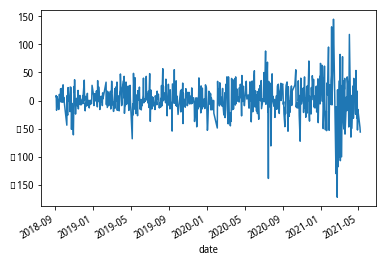

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


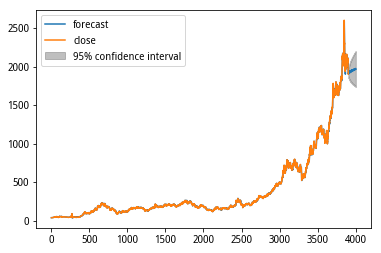

In [79]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = ts1.loc['2018-09':].plot(ax=ax)
plt.show()
fig = model.plot_predict(5,4000)

score:
 0.9992795964853614


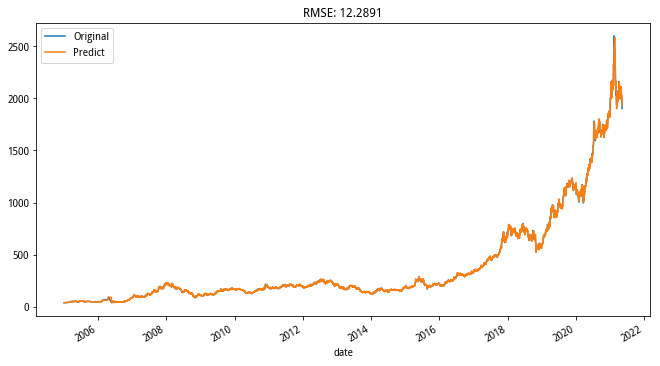

In [78]:
# 样本内预测
predicts = model.predict()

# 因为预测数据是根据差分值算的，所以要对它一阶差分还原
train_shift = ts.shift(1)  # shift是指series往后平移1个时刻
pred_recover = predicts.add(train_shift).dropna()  #这里add是指两列相加，按index对齐

# 模型评价指标 1：计算 score
delta = model.fittedvalues - ts1
score = 1 - delta.var()/ts.var()
print('score:\n', score)

# 模型评价指标 2：使用均方根误差（RMSE）来评估模型样本内拟合的好坏。
#利用该准则进行判别时，需要剔除“非预测”数据的影响。
train_vs = ts[pred_recover.index]  # 过滤没有预测的记录
plt.figure(figsize=(11, 6))
train_vs.plot(label='Original')
pred_recover.plot(label='Predict')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_recover-train_vs)**2)/train_vs.size))
plt.show()

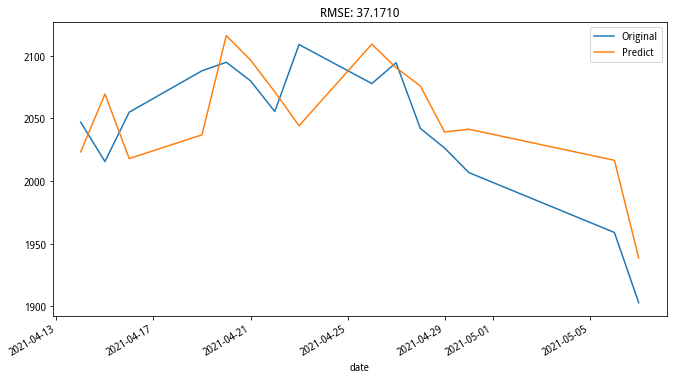

In [81]:
# 局部数据观察
train_t = train_vs.tail(15)
pred_t = pred_recover.tail(15)
plt.figure(figsize=(11, 6))
train_t.plot(label='Original')
pred_t.plot(label='Predict')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_t-train_t)**2)/train_t.size))
plt.show()